## Install Requirements
******Remember to restart the kernel after installing

In [1]:
%pip install --upgrade pip
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.
Ignoring tensorflow: markers 'sys_platform == "linux"' don't match your environment
Ignoring tensorflow: markers 'sys_platform == "windows"' don't match your environment
Ignoring tensorflow-macos: markers 'sys_platform == "darwin"' don't match your environment
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, sys, shutil
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Helper Functions

In [3]:
def calc_median(frames):
    median_frame = np.median(frames, axis=0).astype(dtype=np.uint8)
    return median_frame

def doMovingAverageBGS(image, prev_frames):
    median_img = calc_median(prev_frames)
    image = cv2.absdiff(image, median_img)
    return image

In [4]:
def extractImages(pathIn, pathOut, leakRange, nonleakRange, currCountLeak, currCountNonLeak):

  '''
  Input:
    String: pathIn should be the path of the video 
    String: pathOut should be the path of the folder where data is being stored for testing or training
    Tuple: range of leak frames from video
    Tuple: range of nonleak frames from video

  Output:
    creates two subfolders in pathOut called Leaks and Nonleaks
      Leaks folder contains the frames where there are leaks
      Nonleaks folder contains the frames where there are noleaks
  '''

  leakPath = os.path.join(pathOut, "Leak")
  nonleakPath = os.path.join(pathOut, "Nonleaks")
  
  os.makedirs(leakPath, exist_ok=True)
  os.makedirs(nonleakPath, exist_ok=True)

  def helper(pathIn, pathOut, range, isLeak, currCountLeak, currCountNonLeak):
    '''
    Might need to clean this up, but this was extracted from the original extractImages from the previous implementation
    
    '''
    #setting up moving average list
    prev_imgs = []
    prev_limit = 210 #210 in paper

    start = range[0] * 1000 # converting seconds to milliseconds
    end = range[1] * 1000
    cap = cv2.VideoCapture(pathIn)
    cap.set(cv2.CAP_PROP_POS_MSEC, start)
    success = True

    if cap.isOpened():
      while success and start < end:  
          success, image = cap.read()
          image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

          start = cap.get(cv2.CAP_PROP_POS_MSEC)
          if success:

            prev_imgs.append(image)
            if len(prev_imgs) > prev_limit:
                prev_imgs.pop(0)
          
            processed_img = doMovingAverageBGS(image, prev_imgs) #to generalize might need to make this function as a parameter
            
            if isLeak:
                cv2.imwrite(os.path.join(pathOut, "leak.frame%d.jpg" % currCountLeak), processed_img)     # save frame as JPEG file
                currCountLeak += 1
            else:
                cv2.imwrite(os.path.join(pathOut, "nonleak.frame%d.jpg" % currCountNonLeak), processed_img)
                currCountNonLeak += 1
          else:
            break
      cap.release()
    cv2.destroyAllWindows()
    if isLeak:
       return currCountLeak
    else:
       return currCountNonLeak
  # call helper for both nonLeak and leak and get updated counts
  updated_currCountNonLeak = helper(pathIn, nonleakPath, nonleakRange, isLeak=False, currCountLeak=currCountLeak, currCountNonLeak=currCountNonLeak)
  updated_currCountLeak = helper(pathIn, leakPath, leakRange, isLeak=True,currCountLeak=currCountLeak, currCountNonLeak=currCountNonLeak)
  
  return updated_currCountNonLeak, updated_currCountLeak

## Setting Up Directories

In [4]:
# get generic path to directory
dir_path = os.path.dirname(os.path.realpath("__file__"))

# get all raw video data directories
data_dir = os.path.join(dir_path, 'data')

train_data_dir = os.path.join(data_dir, 'train')
test_data_dir = os.path.join(data_dir, 'test')

frame_data_dir = os.path.join(dir_path, 'frame_data_movingAvg')
frame_train_data_dir = os.path.join(frame_data_dir, 'train')
frame_test_data_dir = os.path.join(frame_data_dir, 'test')

## Setting Up Ranges for Each Video In GasVid (Excluding 18.6m and 8.8m)

In [6]:
raw_data = np.loadtxt(os.path.join(dir_path, 'GasVid_Ranges_Seconds.csv'), skiprows=1, delimiter=',', dtype=int)

ranges = list(zip(raw_data[:, 0], raw_data[:, 1:3], raw_data[:, 3:5])) #need to upload new ranges
ranges = {ranges[i][0] : (ranges[i][1], ranges[i][2]) for i in range(len(ranges))}
len(ranges)

25

In [7]:
def read_frames_from_dir(dir_path, output_path, max_vids=None):
    cur_count = 1
    currNonLeakCount = 0
    currLeakCount = 0
    
    for file in os.listdir(dir_path):
        if max_vids and cur_count > max_vids:
            break
        vid_path = os.path.join(dir_path, file)
        vid_id = int(os.path.basename(vid_path)[4:8])
        if vid_id not in ranges.keys():
            continue

        nonleak_start = ranges[vid_id][0][0]
        nonleak_end = ranges[vid_id][0][1]
        leak_start = ranges[vid_id][1][0]
        leak_end = ranges[vid_id][1][1]

        currNonLeakCount, currLeakCount = extractImages(vid_path, output_path, (leak_start, leak_end), (nonleak_start, nonleak_end), currLeakCount, currNonLeakCount)
        print("Video", vid_id)
        print("Current NonLeak Count", currNonLeakCount)
        print("Current Leak Count", currLeakCount)

        print('Done with', cur_count, "video(s)")
        cur_count += 1
    return currNonLeakCount, currLeakCount

## Reading Frames from Data Directory and Setting Them in Frame Data Directory

In [8]:
image_dim = (240, 320)
vid_count = 15 #max =>15
test_count = 10 #max =>10

total_train_NonLeak, total_train_Leak = read_frames_from_dir(train_data_dir, frame_train_data_dir, vid_count)
print("Done with Training Data")
total_test_NonLeak, total_test_Leak = read_frames_from_dir(test_data_dir, frame_test_data_dir, test_count)
print("Done with Testing Data")
#weird bug in which it if vid_count is 1 goes on to the next one
#might need to cut in amount of samples but we will see

Video 1237
Current NonLeak Count 2387
Current Leak Count 18473
Done with 1 video(s)
Video 1238
Current NonLeak Count 4770
Current Leak Count 36963
Done with 2 video(s)
Video 1239
Current NonLeak Count 7162
Current Leak Count 55437
Done with 3 video(s)
Video 1240
Current NonLeak Count 9544
Current Leak Count 73935
Done with 4 video(s)
Video 1242
Current NonLeak Count 11929
Current Leak Count 92423
Done with 5 video(s)
Video 2559
Current NonLeak Count 14315
Current Leak Count 110887
Done with 6 video(s)
Video 2560
Current NonLeak Count 16692
Current Leak Count 129340
Done with 7 video(s)
Video 2561
Current NonLeak Count 19081
Current Leak Count 147804
Done with 8 video(s)
Video 2562
Current NonLeak Count 21465
Current Leak Count 166264
Done with 9 video(s)
Video 2564
Current NonLeak Count 23853
Current Leak Count 184735
Done with 10 video(s)
Video 2566
Current NonLeak Count 26236
Current Leak Count 203211
Done with 11 video(s)
Video 2567
Current NonLeak Count 28621
Current Leak Count 221

In [5]:
total_train_NonLeak, total_train_Leak = 35779, 277114
total_test_NonLeak, total_test_Leak = 23857, 184811

## Setting Up Generators for Training, Validation, and Testing

In [53]:
from keras.preprocessing.image import ImageDataGenerator

val_split = 0.2
batch_size = 32
target_size = (240, 320)


train_datagen = ImageDataGenerator(
    # featurewise_center=True, #cant do this as need entire dataset to do it | need to figure out a way in doing this
    # featurewise_std_normalization=True,
    rescale=1. / 255,
    validation_split=val_split,
)

train_generator = train_datagen.flow_from_directory(
    directory=frame_train_data_dir,
    class_mode="binary",
    subset="training",
    batch_size=batch_size,
    color_mode="grayscale",
    target_size=target_size,
    classes=["Nonleaks", "Leak"]

)

val_generator = train_datagen.flow_from_directory(
    directory=frame_train_data_dir,
    class_mode="binary",
    subset="validation",
    batch_size=batch_size,
    color_mode="grayscale",
    target_size=target_size,
    classes=["Nonleaks", "Leak"]

)


test_datagen = ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    rescale=1. / 255,
)

test_generator = test_datagen.flow_from_directory(
    directory=frame_test_data_dir, 
    class_mode='binary', 
    batch_size=batch_size,
    color_mode="grayscale",
    target_size=target_size,
    classes=["Nonleaks", "Leak"]

)


Found 250316 images belonging to 2 classes.
Found 62577 images belonging to 2 classes.
Found 208668 images belonging to 2 classes.


In [54]:
total_train_frames = total_train_NonLeak + total_train_Leak
total_train_frames

312893

In [55]:
total_batches = train_generator.__len__() + val_generator.__len__()
total_batches

9779

In [56]:
train_generator.class_indices

{'Nonleaks': 0, 'Leak': 1}

## Class Weights

In [57]:
nonleaks = total_train_NonLeak
leaks = total_train_Leak
total = nonleaks + leaks

weight_nonleak = (1 / nonleaks) * (total / 2.0)
weight_leak = (1 / leaks) * (total / 2.0)

class_weight = {train_generator.class_indices["Nonleaks"]: weight_nonleak, train_generator.class_indices["Leak"]: weight_leak}
class_weight

{0: 4.372578887056654, 1: 0.564556464126677}

In [58]:
def generator_mean(generators):
    feature_sum = 0
    num_elements = 0
    total_batches = 0
    for generator in generators: #had to include this as I am splitting training data with validation data
        batches = 0
        print("Length of Generator", len(generator))
        for data, _ in generator:
            feature_sum += np.sum(data, axis=(0, 1, 2), dtype=np.float64)
            num_elements += np.prod(data.shape[0:3], dtype=np.int64)
            if batches >= len(generator):
                # we need to break the loop by hand because
                # the generator loops indefinitely
                print("Done with one generator!")
                break
            batches += 1
            total_batches += 1
    print("Total Batches", total_batches)
    for generator in generators:
        generator.reset()
        print("Reset Generator")
    return feature_sum/num_elements

def generator_std(generators, mean, centerFirst):
    sum_squared_diff = 0
    num_elements = 0
    total_batches = 0
    og_gens = generators
    lengths_of_gens = [len(gen) for gen in generators]
    if centerFirst:
        generators = [get_with_featurewise_center(gen, mean) for gen in generators]
    for i, generator in enumerate(generators): 
        batches = 0
        print("Length of Generator", lengths_of_gens[i])
        for data, _ in generator:
            squared_diff = (data - mean) ** 2
            sum_squared_diff += np.sum(squared_diff, axis=(0, 1, 2), dtype=np.float64)
            num_elements += np.prod(data.shape[0:3], dtype=np.int64)

            if batches >= lengths_of_gens[i]:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                print("Done with one generator!")
                break
            batches += 1
            total_batches += 1
    print("Total Batches", total_batches)
    for generator in og_gens:
        generator.reset()
        print("Reset Generator")
    return np.sqrt(sum_squared_diff / (num_elements - 1), dtype=np.float64)

def get_with_featurewise_center(generator, mean):
    for data, labels in generator:
        if mean:
            data -= mean
        yield data, labels

def get_with_featurewise_std_norm(generator, std):
    for data, labels in generator:
        if std:
            data /= (std + 1e-6)
        yield data, labels

def get_with_featurewise_center_std_norm (generator, mean, std):
    for data, labels in generator:
        if mean:
            data -= mean
        if std:
            data /= (std + 1e-6)
        yield data, labels

def generate_stats(gens, centerFirst):
    print("Calculating mean...")
    mean = generator_mean(generators=gens)
    print("Done!")
    print("Calculating std from centered data...")
    std = generator_std(generators=gens, mean=mean, centerFirst=centerFirst)
    print("Done!")
    return mean, std

In [59]:
mean, std = generate_stats(gens=[train_generator, val_generator], centerFirst=True)
mean, std #takes a long time not sure if there is an infinite loop - correction there was an infinite loop :))) now should run for less than 10 mins 

Calculating mean...
Length of Generator 7823
Done with one generator!
Length of Generator 1956
Done with one generator!
Total Batches 9779
Reset Generator
Reset Generator
Done!
Calculating std from centered data...
Length of Generator 7823
Done with one generator!
Length of Generator 1956
Done with one generator!
Total Batches 9779
Reset Generator
Reset Generator
Done!


(array([0.00709404]), array([0.01582675]))

In [60]:
mean = mean[0]
std = std[0]
mean, std

(0.007094042456514309, 0.015826752292189675)

## Sample Weigths

In [ ]:
#TODO: calculate sample_weights using train_generator | should be similar to how predictions are made at the bottom of the notebook
#I think this should work but not sure

# A DirectoryIterator yielding tuples of (x, y) where x is a numpy array 
# containing a batch of images with shape (batch_size, *target_size, channels) 
# and y is a numpy array of corresponding labels. (In our case its train_generator)

# def sample_weights(data):
#     weights = []
#     zero_sum = 0
#     for data, _ in train_generator:
#        batch_size = data.shape[0]
#        for image_index in range(batch_size):
#             image = data[image_index]
#             summed_pixels = np.sum(image)
#             if summed_pixels == 0:
#                 weights.append(0)
#                 zero_sum += 1
#             else:
#                 # try using sqrt transformation for weight skew
#                 # weights.append(1 / np.sqrt(summed_pixels))
#                 weights.append(1 / summed_pixels)
#     train_generator.reset()
#     median_weight = np.median(weights)
#     weights = [median_weight if weight == 0 else weight for weight in weights]
#     return weights

## Model

In [61]:
from keras import layers 
from keras import models 

model = models.Sequential() 

# Conv Pool 1
model.add(layers.Conv2D(4, (3, 3), input_shape=(240, 320, 1)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

# Conv Pool 2
model.add(layers.Conv2D(8, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

# Conv Pool 3
model.add(layers.Conv2D(8, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

# Conv Pool4
model.add(layers.Conv2D(4, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())

model.add(layers.Dense(2400, activation='relu')) 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu')) 
model.add(layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 318, 4)       40        
                                                                 
 batch_normalization (BatchN  (None, 238, 318, 4)      16        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 238, 318, 4)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 119, 159, 4)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 119, 159, 4)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 157, 8)       2

## Data Visualization (Confusion Matrix and ROC Curves)

In [ ]:
#code from https://neptune.ai/blog/keras-metrics
#to use to plot confusion matrix and roc curve after each epock
#uncomment when you need it 

import os

from keras.callbacks import Callback
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

class PerformanceVisualizationCallback(Callback):
    def __init__(self, model, validation_data, num_batches, image_dir):
        super().__init__()
        self.model = model
        self.validation_data = validation_data
        self.num_batches = num_batches

        os.makedirs(image_dir, exist_ok=True)
        self.image_dir = image_dir

    def on_epoch_end(self, epoch, logs={}):
        y_true = []
        y_pred = []
        batch_num = 0
        for data, true_label in validation_data:
            batch_pred = self.model.predict(data)
            y_pred.append(batch_pred)
            y_true.append(true_label)

            if batch_num >= self.num_batches:
                break

        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)
        

        # plot and save confusion matrix
        fig, ax = plt.subplots(figsize=(16,12))
        cm = confusion_matrix(y_true, y_pred)
        cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax, name=f"Confusion Matrix of Validation Data at Epoch {epoch}")
        fig.savefig(os.path.join(self.image_dir, f'confusion_matrix_epoch_{epoch}'))

       # plot and save roc curve
        fig, ax = plt.subplots(figsize=(16,12))
        
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax, name=f"ROC Curve of Validation Data at Epoch {epoch}")
        fig.savefig(os.path.join(self.image_dir, f'roc_curve_epoch_{epoch}'))

performance_cbk = PerformanceVisualizationCallback(
                      model=model,
                      validation_data=get_with_featurewise_center_std_norm(val_generator, mean, std),
                      num_batches=len(val_generator)
                      image_dir='performance_vizualizations')

## Training Model

In [62]:
from keras import optimizers 
from keras import metrics

def F1Score(y_true, y_pred):
    prec = metrics.Precision()
    recall = metrics.Recall()
    prec.update_state(y_true, y_pred)
    recall.update_state(y_true, y_pred)
    prec_res = prec.result().numpy()
    rec_res = recall.result().numpy()
    return 2 * (prec_res * rec_res) / (prec_res + rec_res)

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-4), metrics=[F1Score, "acc"], run_eagerly=True)


In [63]:

num_epochs = 5

history = model.fit_generator(
    generator = get_with_featurewise_center_std_norm(train_generator, mean, std),
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = get_with_featurewise_center_std_norm(val_generator, mean, std),
    validation_steps = val_generator.samples // batch_size,
    epochs = num_epochs,
    class_weight = class_weight,
    callbacks=[performance_cbk] #uncomment once you want to use it
)

Epoch 1/5


C:\Users\bestlab\AppData\Local\Temp\ipykernel_15752\2780847332.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


7822/7822 [==============================] - 4107s 525ms/step - loss: 0.2217 - F1Score: 0.9239 - acc: 0.8773 - val_loss: 2.2144 - val_F1Score: 0.4058 - val_acc: 0.3445
Epoch 2/5
7822/7822 [==============================] - ETA: 0s - loss: 0.1299 - F1Score: 0.9622 - acc: 0.9363

C:\Users\bestlab\AppData\Local\Temp\__autograph_generated_fileo6iu6jga.py:18: RuntimeWarning: invalid value encountered in double_scalars
  retval_ = 2 * (ag__.ld(prec_res) * ag__.ld(rec_res)) / (ag__.ld(prec_res) + ag__.ld(rec_res))


7822/7822 [==============================] - 4108s 525ms/step - loss: 0.1299 - F1Score: 0.9622 - acc: 0.9363 - val_loss: 3.0832 - val_F1Score: nan - val_acc: 0.3186
Epoch 3/5
7822/7822 [==============================] - 4115s 526ms/step - loss: 0.0913 - F1Score: 0.9751 - acc: 0.9575 - val_loss: 3.4342 - val_F1Score: 0.3921 - val_acc: 0.3347
Epoch 4/5
7822/7822 [==============================] - 4121s 527ms/step - loss: 0.0655 - F1Score: 0.9836 - acc: 0.9718 - val_loss: 3.0686 - val_F1Score: 0.4357 - val_acc: 0.3661
Epoch 5/5
7822/7822 [==============================] - 4119s 527ms/step - loss: 0.0505 - F1Score: 0.9881 - acc: 0.9794 - val_loss: 2.8379 - val_F1Score: 0.4266 - val_acc: 0.3594


## Model Metrics Over Epochs

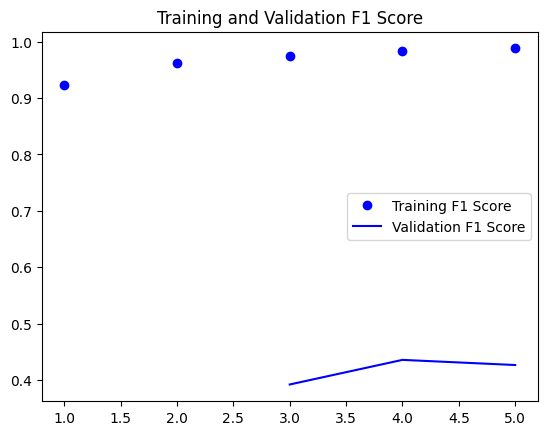

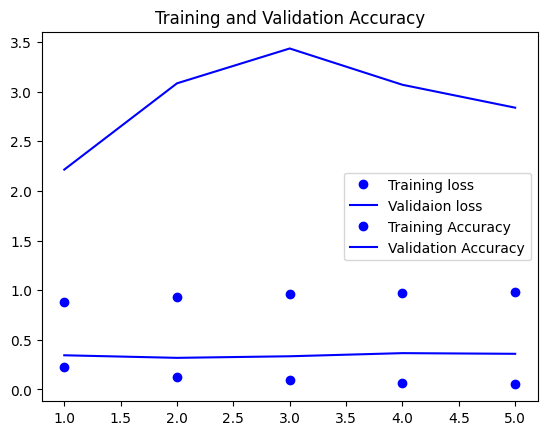

<Figure size 640x480 with 0 Axes>

In [64]:
import matplotlib.pyplot as plt 

f1 = history.history['F1Score'] 
val_f1 = history.history['val_F1Score'] 

loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

acc = history.history["acc"]
val_acc = history.history["val_acc"]

epochs = range(1, len(f1) + 1) 

plt.plot(epochs, f1, 'bo', label='Training F1 Score') 
plt.plot(epochs, val_f1, 'b', label='Validation F1 Score') 
plt.title('Training and Validation F1 Score') 
plt.legend() 

plt.figure() 

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validaion loss') 
plt.title('Training loss and validation loss') 
plt.legend() 

plt.plot(epochs, acc, 'bo', label='Training Accuracy') 
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy') 
plt.title('Training and Validation Accuracy') 
plt.legend() 

plt.figure() 

plt.show() 

## Testing

In [65]:
test_mean, test_std = generate_stats(gens=[test_generator], centerFirst=True)
test_mean, test_std

Calculating mean...
Length of Generator 6521
Done with one generator!
Total Batches 6521
Reset Generator
Done!
Calculating std from centered data...
Length of Generator 6521
Done with one generator!
Total Batches 6521
Reset Generator
Done!


(array([0.00596221]), array([0.01576755]))

In [66]:
test_mean = test_mean[0]
test_std = test_std[0]

In [67]:
#source: https://stackoverflow.com/questions/45413712/keras-get-true-labels-y-test-from-imagedatagenerator-or-predict-generator

# Create lists for storing the predictions and labels
predictions = []
true_labels = []

threshold = 0.5
# Get the total number of labels in generator 
# (i.e. the length of the dataset where the generator generates batches from)
length_test = len(test_generator.labels)

# Loop over the generator
for data, label in get_with_featurewise_center_std_norm(test_generator, test_mean, test_std):
    # Make predictions on data using the model. Store the results.
    preds = model.predict(data, verbose=0)
    processed_preds = (preds >= threshold).flatten().astype(int)
    predictions.extend(processed_preds)
    # Store corresponding labels
    true_labels.extend(label.astype(int))
    
    # We have to break out from the generator when we've processed 
    # the entire once (otherwise we would end up with duplicates). 
    if len(predictions) == length_test:
        break

In [68]:
len(predictions), len(true_labels)

(208668, 208668)

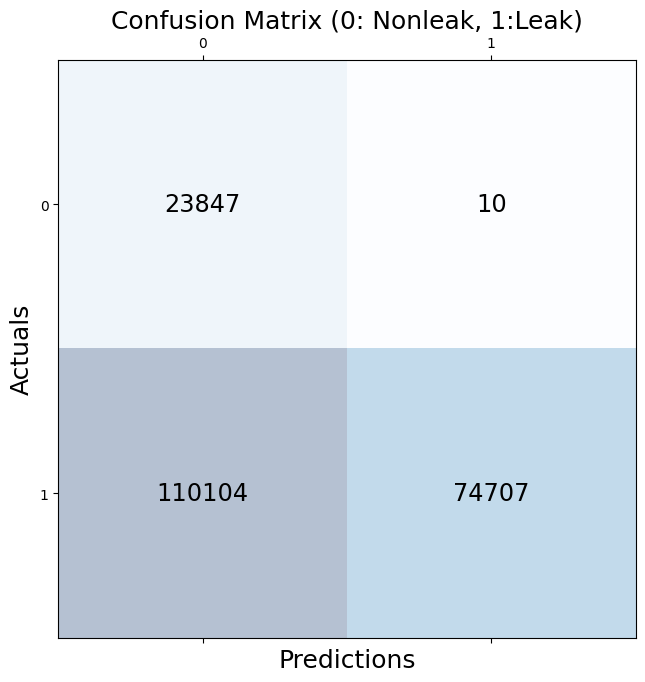

In [69]:
from sklearn.metrics import confusion_matrix

#source: https://vitalflux.com/python-draw-confusion-matrix-matplotlib/

conf_matrix = confusion_matrix(y_true=true_labels, y_pred=predictions)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix (0: Nonleak, 1:Leak)', fontsize=18)
plt.show()

In [71]:
# Extract the true positive, true negative, false positive, and false negative values from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()
 
# Print the true positive, true negative, false positive, and false negative values
print("True Positive (TP): ", tp)
print("True Negative (TN): ", tn)
print("False Positive (FP): ", fp)
print("False Negative (FN): ", fn)
 
# Calculate accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)
 
# Calculate precision
precision = tp / (tp + fp)
 
# Calculate recall
recall = tp / (tp + fn)
 
# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)
 
# Print the formulas for accuracy, precision, recall, and F1-score
print("\n\nFormulas:")
print("Accuracy: (TP + TN) / (TP + TN + FP + FN)")
print("Precision: TP / (TP + FP)")
print("Recall: TP / (TP + FN)")
print("F1-score: 2 * (Precision * Recall) / (Precision + Recall)")
 
# Print the accuracy, precision, recall, and F1-score
print("\n\nMetrics:")
print("Accuracy: ", round(accuracy, 4))
print("Precision: ", round(precision, 4))
print("Recall: ", round(recall, 4))
print("F1-score: ", round(f1_score, 4))

True Positive (TP):  74707
True Negative (TN):  23847
False Positive (FP):  10
False Negative (FN):  110104


Formulas:
Accuracy: (TP + TN) / (TP + TN + FP + FN)
Precision: TP / (TP + FP)
Recall: TP / (TP + FN)
F1-score: 2 * (Precision * Recall) / (Precision + Recall)


Metrics:
Accuracy:  0.4723
Precision:  0.9999
Recall:  0.4042
F1-score:  0.5757


In [1]:


def get_test_FN_frames(generator, total):
    res = []
    fn_indices = [i for i in range(len(predictions)) if predictions[i] == 0 and true_labels[i] == 1]
    fn_indices = np.random.choice(fn_indices, total, replace=False)
    fn_set = set(fn_indices)
    batch_num = 0
    for i in range(total):
        i_fn = fn_indices[i]
        i_batch = i_fn // batch_size
        data, _ = generator.__getitem__(i_batch)
        res.append(data[i_fn % batch_size])
    return res
frames_FN = get_test_FN_frames(test_generator, 10)
frames_FN

NameError: name 'test_generator' is not defined

In [81]:
def plot_images(images):
    for i, img in enumerate(images):
        cv2.imshow(f"Image {i + 1}", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
plot_images(frames_FN)